In [106]:
import numpy as np
import h5py
import yaml
import os
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('dark_background')


In [107]:
run_duration = 360
outro_duration, intro_duration = 16, 16
trial_duration = 4
total_n_trials = int(run_duration / trial_duration)
n_empty_trials = 10
print(total_n_trials)

90


### Train trials, 
uniformly distributed across the circle

In [108]:
def train_run_orientations(total_n_trials=90, 
                        n_empty_trials=10, 
                        n_ori_distribution_blocks=4,
                        empty_trial_slack=2,
                        orientation_offset=0):
    """
    Returns a list of trial orientations, one for each trial.
    """
    basic_orientations = np.linspace(-np.pi, np.pi, total_n_trials-n_empty_trials, endpoint=False) + orientation_offset

    empty_stride_f = total_n_trials/(n_empty_trials+1)
    empty_trials = np.cumsum(np.ones(n_empty_trials)*empty_stride_f).astype(int)
    empty_trials += np.random.randint(-2,2,size=len(empty_trials))

    random_orientations = np.array([np.random.permutation(a) 
                                    for a in [basic_orientations[i::n_ori_distribution_blocks] 
                                                        for i in range(n_ori_distribution_blocks)]]).ravel()
    
    radians = np.zeros(total_n_trials)
    skip = 0
    for i in range(total_n_trials):
        if i in empty_trials:
            radians[i] = np.nan
            skip += 1
        else:
            radians[i] = random_orientations[i-skip]
    df_data = np.zeros((total_n_trials, 4))
    df_data[:,[0,1,2]] = [0, np.nan, np.nan]
    df_data[:,3] = radians
    data_df = pd.DataFrame(df_data, columns=['block', 'block_mean', 'block_kappa', 'radians'])
    data_df['color'] = 'blue'
    data_df.loc[np.isnan(data_df['radians']), 'color'] = 'black'
    data_df['rounded_orientation_degrees'] = np.degrees(data_df['radians']/2)
    data_df['grating_phase'] = np.random.rand(len(data_df))
    data_df['grating_contrast_multiplier'] = np.ones(len(data_df)) * ~np.isnan(data_df['radians'])
    # data_df['grating_contrast_multiplier'][data_df['radians']==np.nan] = 0

    return data_df

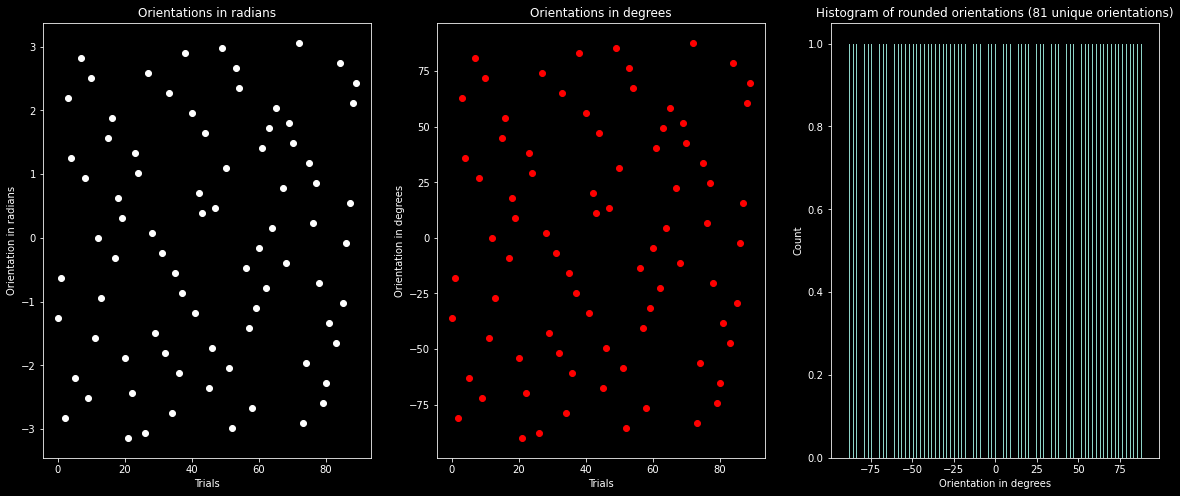

In [109]:
train_df = train_run_orientations()

def plot_train_run_orientations(train_df, fn='run_designs/train_orientations.pdf'):
    f, axs = plt.subplots(1,3,figsize=(20,8))

    axs[0].plot(train_df['radians'], 'wo')
    axs[0].set_title('Orientations in radians')
    axs[0].set_xlabel('Trials')
    axs[0].set_ylabel('Orientation in radians')
    axs[1].plot(train_df['rounded_orientation_degrees'], 'ro')
    axs[1].set_title('Orientations in degrees')
    axs[1].set_xlabel('Trials')
    axs[1].set_ylabel('Orientation in degrees')
    axs[2].hist(train_df['rounded_orientation_degrees'], bins=np.arange(-90,90,0.5))
    axs[2].set_title(f'Histogram of rounded orientations ({len(np.unique(train_df["rounded_orientation_degrees"]))} unique orientations)')
    axs[2].set_xlabel('Orientation in degrees')
    axs[2].set_ylabel('Count')
    
    plt.savefig(fn)

plot_train_run_orientations(train_df)

## Test trials

these implement blocks with different spreads and mean orientations

(0.0, 3.141592653589793)

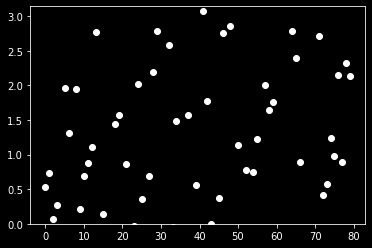

In [110]:
plt.plot(np.random.vonmises(np.pi/4, 0.5, total_n_trials-n_empty_trials), 'wo')
plt.ylim([0,np.pi])

In [111]:
# blocks defined in the range -np.pi, np.pi for von mises generation of trial values. 
# scale back to 0, np.pi for orientation afterwards. 

red_n_blocks, green_n_blocks = np.random.randint(2,7,2)

red_means = np.random.permutation(np.fmod(np.random.rand() + np.linspace(0, 1, red_n_blocks, endpoint=False), 1) * np.pi * 2 -np.pi)
green_means = np.random.permutation(np.fmod(np.random.rand() + np.linspace(0, 1, green_n_blocks, endpoint=False), 1) * np.pi * 2 -np.pi)

# these values are calculated later on, but it's handy to hardcode them here.
# values below are for an overlap of 2.2 (for an x array of 10000 values, see below)
blocks_optimal_kappas = [[2,3,4,5,6,7,8,9,10], 
                        [0.535578,  0.752727,  1.718991,  3.661899, 6.167782, 9.352917, 13.278907, 17.979412, 23.484812]]

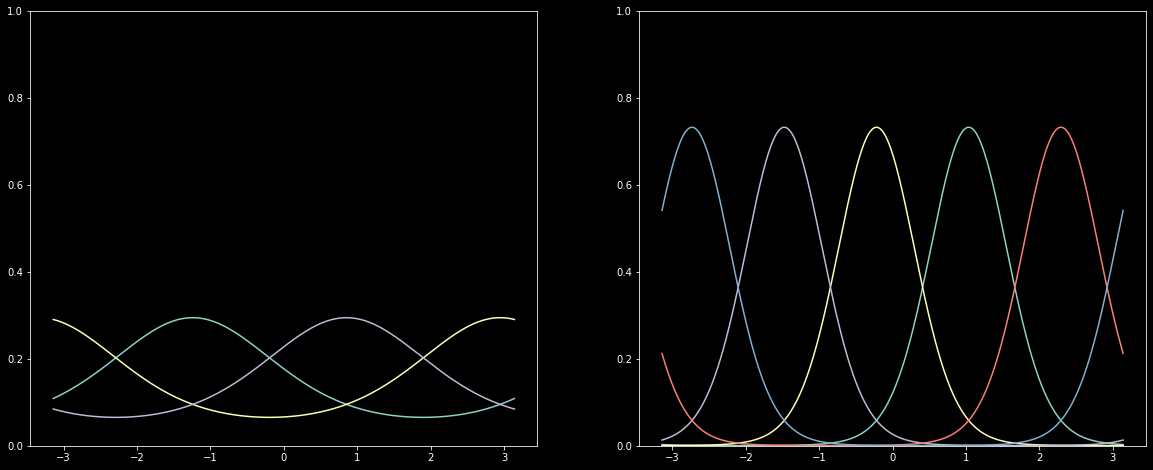

In [112]:
f, axs = plt.subplots(1,2,figsize=(20,8))
axs[0].set_ylim([0,1])
axs[1].set_ylim([0,1])
for rm in red_means:
    axs[0].plot(np.linspace(-np.pi, np.pi, 1000), 
                stats.vonmises.pdf(np.linspace(-np.pi, np.pi, 1000), kappa=blocks_optimal_kappas[1][blocks_optimal_kappas[0].index(len(red_means))], loc=rm))
for gm in green_means:
    axs[1].plot(np.linspace(-np.pi, np.pi, 1000), 
                stats.vonmises.pdf(np.linspace(-np.pi, np.pi, 1000), kappa=blocks_optimal_kappas[1][blocks_optimal_kappas[0].index(len(green_means))], loc=gm))                

### Calculate kappa values for each of the possible number of blocks in a run

In [113]:
def overlap_vm(n_blocks, kappa_function):
    x = np.linspace(-np.pi, np.pi, 100)
    locs = [0, 2*np.pi/n_blocks]
    return np.array([np.dot(stats.vonmises.pdf(x, kappa=k, loc=locs[0]), stats.vonmises.pdf(x, kappa=k, loc=locs[1])) 
        for k in kappa_function])

,kappa
n blocks,
2,0.534845
3,0.752275
4,1.716859
5,3.656479
6,6.155868
7,9.364217
8,13.293019
9,17.937163
10,23.435265


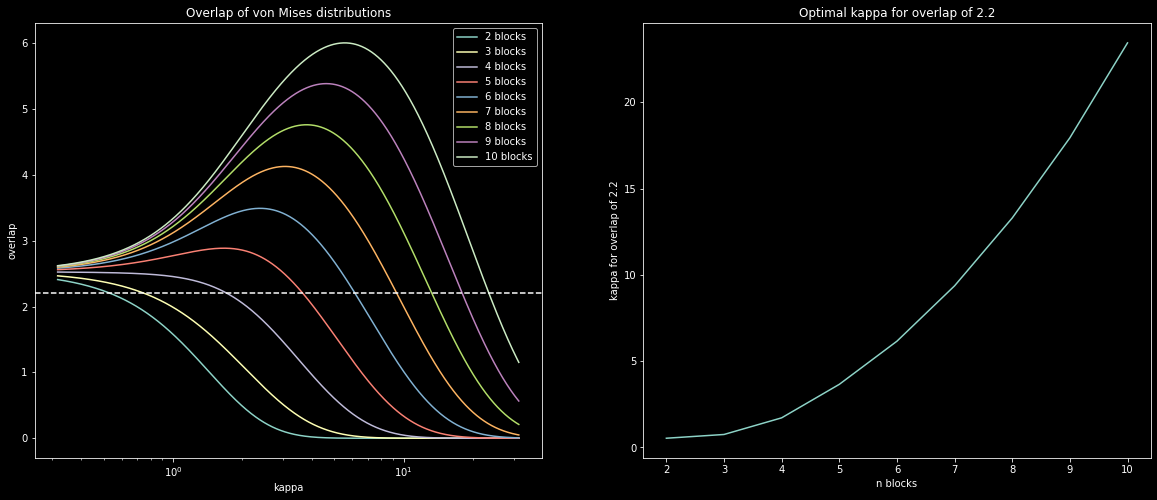

In [114]:
desired_vm_overlap = 2.2
f, axs = plt.subplots(1,2,figsize=(20,8))
x = np.logspace(-0.5, 1.5, 1000)
for n in [2,3,4,5,6,7,8,9,10]:
    axs[0].semilogx(x, overlap_vm(n_blocks=n, kappa_function=x), label=f'{n} blocks')
axs[0].axhline(desired_vm_overlap, color='w', linestyle='--')
axs[0].legend()
axs[0].set_xlabel('kappa')
axs[0].set_ylabel('overlap')
axs[0].set_title('Overlap of von Mises distributions')
best_kappas = np.array([x[np.argmin(np.abs(overlap_vm(n_blocks=n, kappa_function=x)-desired_vm_overlap))] 
                    for n in [2,3,4,5,6,7,8,9,10]])
axs[1].plot([2,3,4,5,6,7,8,9,10], best_kappas)
axs[1].set_xlabel('n blocks')
axs[1].set_ylabel(f'kappa for overlap of {desired_vm_overlap}')
axs[1].set_title(f'Optimal kappa for overlap of {desired_vm_overlap}')

best_kappa_df = pd.DataFrame(best_kappas, columns=['kappa'], index=pd.Series([2,3,4,5,6,7,8,9,10], name='n blocks'))
best_kappa_df

## Code up the blocks and orientations

In [115]:
def test_run_orientations(total_n_trials=90, 
                        n_empty_trials=10, 
                        min_n_blocks=2,
                        max_n_blocks=6,
                        empty_trial_slack=2,
                        block_duration_slack=10):
    """
    Returns a list of trial orientations, one for each trial.
    """
    empty_stride_f = total_n_trials/(n_empty_trials+1)
    empty_trials = np.cumsum(np.ones(n_empty_trials)*empty_stride_f).astype(int)
    empty_trials += np.random.randint(-empty_trial_slack,empty_trial_slack+1,size=len(empty_trials))

    n_trials_each_color = (total_n_trials - n_empty_trials)//2
    red_n_blocks, green_n_blocks = np.random.randint(min_n_blocks,max_n_blocks,2)
    color_trial_dict = {}
    for i, color in enumerate(['red', 'green']):
        n_blocks = [red_n_blocks, green_n_blocks][i]
        n_trials_per_block = n_trials_each_color / n_blocks
        color_trials = np.cumsum(np.ones(n_blocks)*n_trials_per_block).astype(int)
        color_trials += np.random.randint(-(block_duration_slack//n_trials_per_block),(block_duration_slack//n_trials_per_block)+1,size=len(color_trials))
        color_trials = np.r_[0,color_trials]
        color_trials[-1] = n_trials_each_color
        color_trial_indices = [np.arange(color_trials[j], color_trials[j+1]) for j in range(len(color_trials)-1)]
        block_means = np.random.permutation(np.fmod(np.random.rand() + np.linspace(0, 1, n_blocks, endpoint=False), 1) * np.pi * 2 -np.pi)
        block_kappas = np.ones(n_blocks) * blocks_optimal_kappas[1][blocks_optimal_kappas[0].index(n_blocks)]
        radians = [np.random.vonmises(mu=bm, kappa=bk, size=len(ind)) for bm, bk, ind in zip(block_means, block_kappas, color_trial_indices)]
        df_data = np.zeros((n_trials_each_color, 4))
        for b in range(n_blocks):
            df_data[color_trial_indices[b], 0] = b+1
            df_data[color_trial_indices[b], 1] = block_means[b]
            df_data[color_trial_indices[b], 2] = block_kappas[b]
        df_data[:,-1] = np.concatenate(radians)
        data_df = pd.DataFrame(df_data, columns=['block', 'block_mean', 'block_kappa', 'radians'])
        data_df['color'] = color
        color_trial_dict[color] = {'data_df': data_df, 'trials': color_trials, 'means':block_means, 'kappas':block_kappas, 'indices': color_trial_indices, 'radians': radians}
        
    which_color_which_trial = np.random.permutation(np.r_[np.zeros(n_trials_each_color), np.ones(n_trials_each_color)]).astype(bool)
    all_color_df = pd.DataFrame(np.zeros((which_color_which_trial.shape[0], 5)), 
                        columns=['block', 'block_mean', 'block_kappa', 'radians', 'color'])
    all_color_df.iloc[which_color_which_trial] = color_trial_dict['red']['data_df']
    all_color_df.iloc[~which_color_which_trial] = color_trial_dict['green']['data_df']
    all_color_df['grating_contrast_multiplier'] = np.ones(len(all_color_df))

    for et in empty_trials:
        all_color_df.loc[et-0.5] = [0, np.nan, np.nan, np.nan, 'black', 0] 
    all_color_df = all_color_df.sort_index().reset_index(drop=True)
    all_color_df['rounded_orientation_degrees'] = np.round(np.degrees(all_color_df['radians']) / 10) * 5
    all_color_df['grating_phase'] = np.random.rand(len(all_color_df))

    return all_color_df


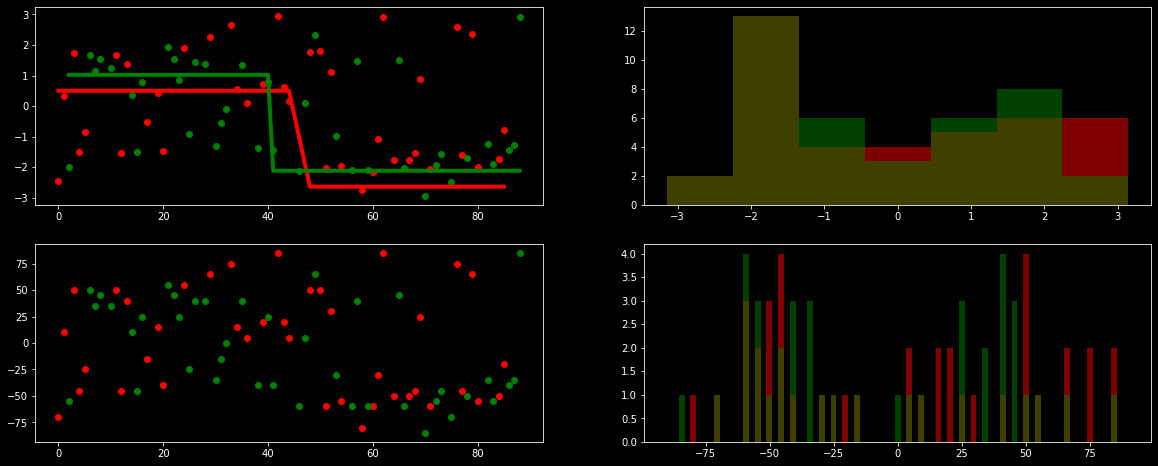

In [116]:
df = test_run_orientations()

def plot_test_run_orientations(df, fn='run_designs/test_orientations.pdf'):
    f, axs = plt.subplots(2,2,figsize=(20,8))

    axs[0][0].plot(df.index[df['color']=='red'], df['radians'][df['color']=='red'], 'ro')
    axs[0][0].plot(df.index[df['color']=='green'], df['radians'][df['color']=='green'], 'go')
    axs[0][0].plot(df.index[df['color']=='red'], df['block_mean'][df['color']=='red'], 'r-', lw=4)
    axs[0][0].plot(df.index[df['color']=='green'], df['block_mean'][df['color']=='green'], 'g-', lw=4)
    axs[0][1].hist(df['radians'][df['color']=='red'], bins=np.linspace(-np.pi, np.pi, 8), color='r', alpha=0.5)
    axs[0][1].hist(df['radians'][df['color']=='green'], bins=np.linspace(-np.pi, np.pi, 8), color='g', alpha=0.5)

    axs[1][0].plot(df.index[df['color']=='red'], df['rounded_orientation_degrees'][df['color']=='red'], 'ro')
    axs[1][0].plot(df.index[df['color']=='green'], df['rounded_orientation_degrees'][df['color']=='green'], 'go')
    axs[1][1].hist(df['rounded_orientation_degrees'][df['color']=='red'], bins=np.linspace(-90, 90, 80), color='r', alpha=0.5)
    axs[1][1].hist(df['rounded_orientation_degrees'][df['color']=='green'], bins=np.linspace(-90, 90, 80), color='g', alpha=0.5);
    plt.savefig(fn)
    
plot_test_run_orientations(df)

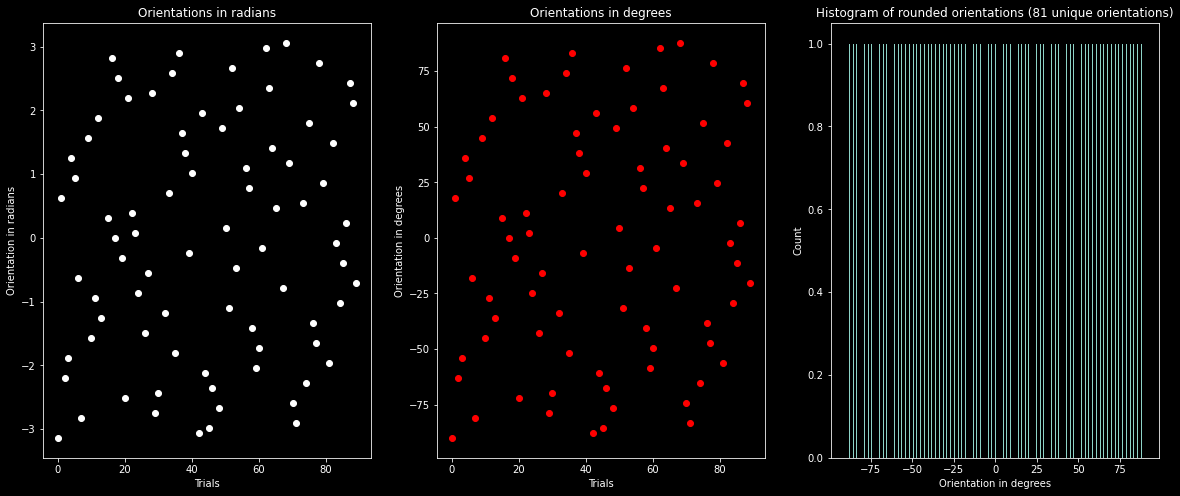

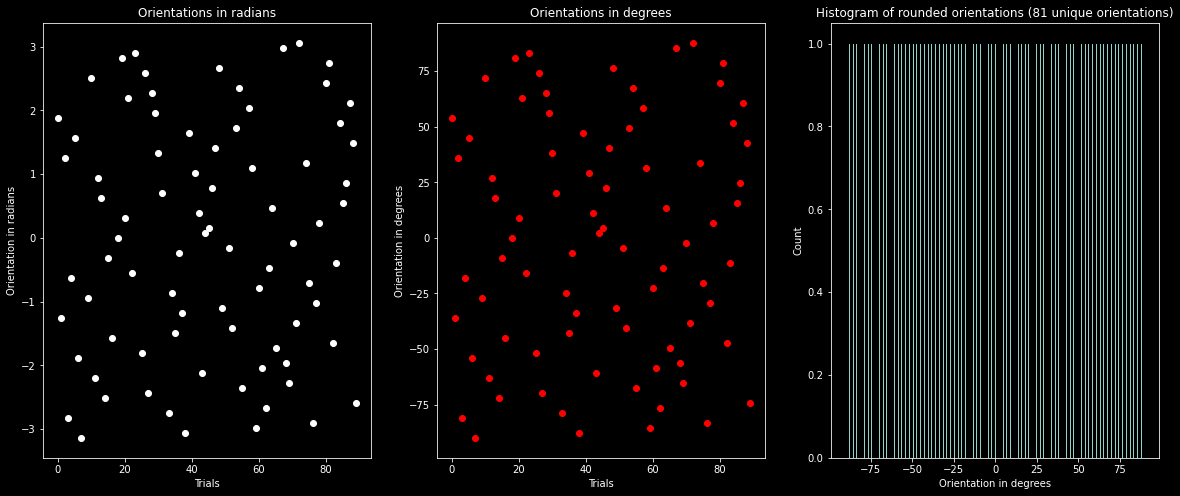

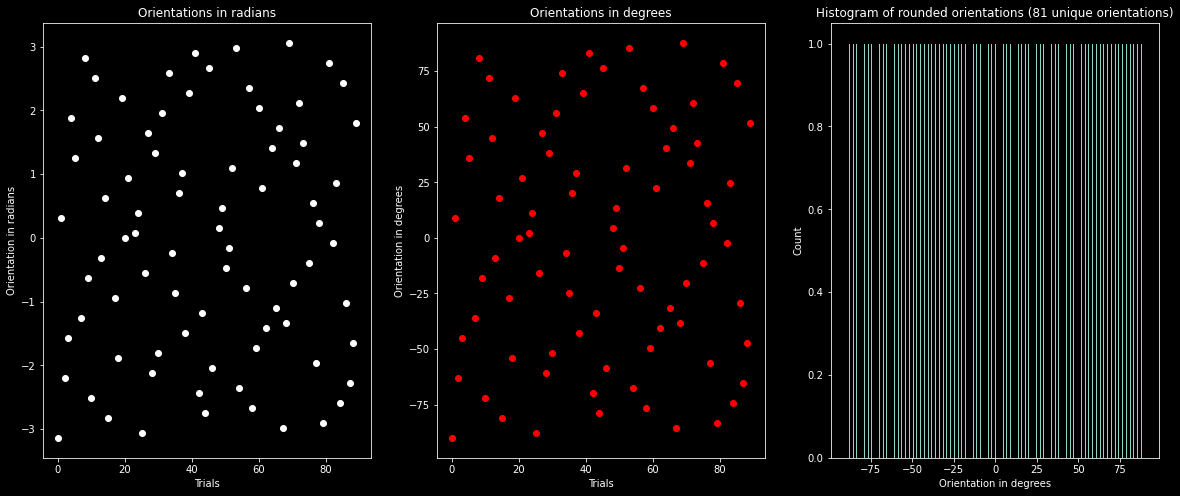

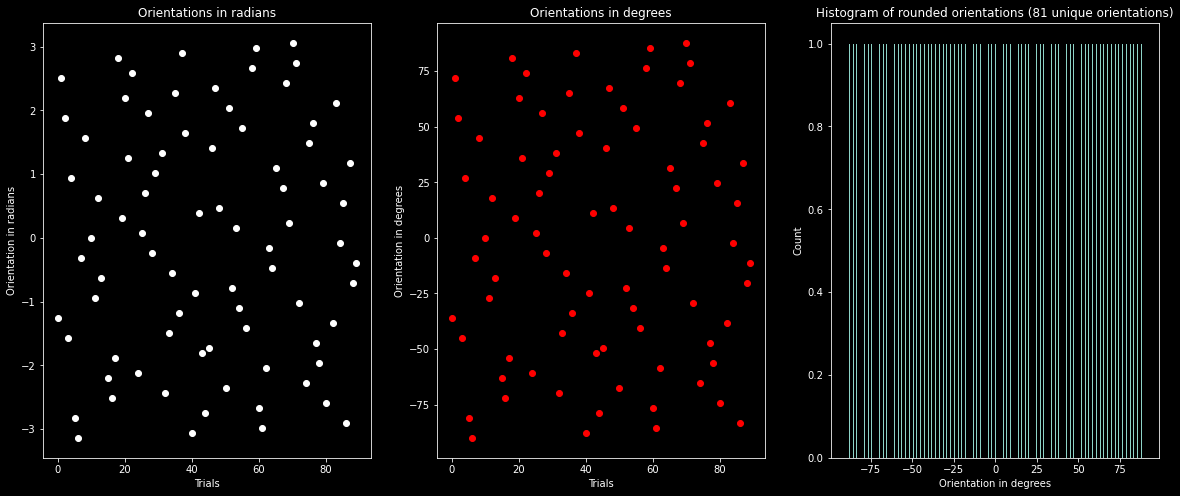

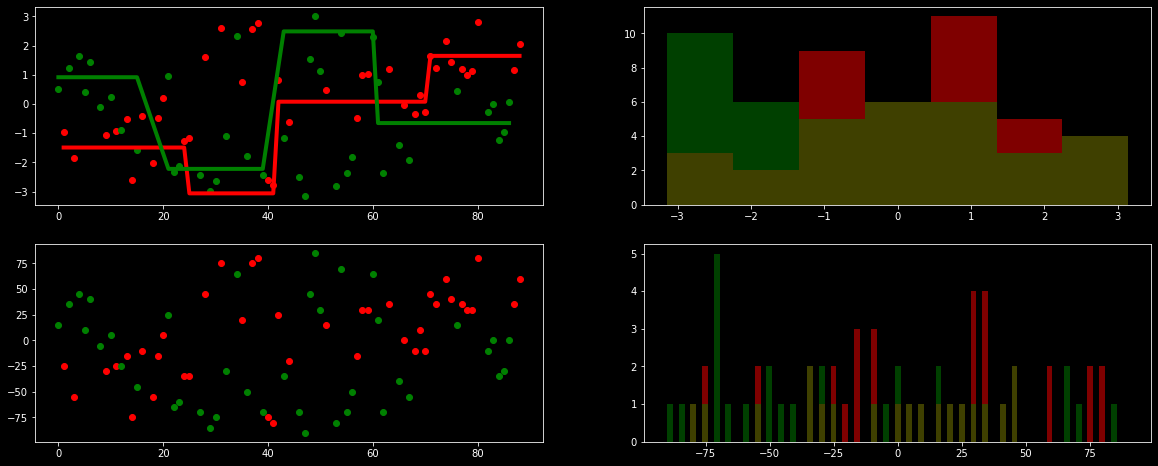

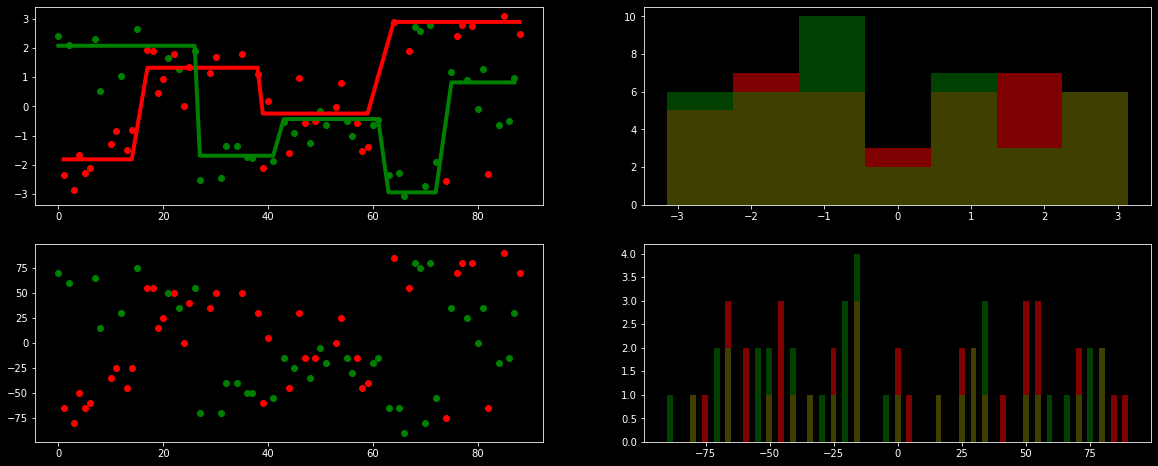

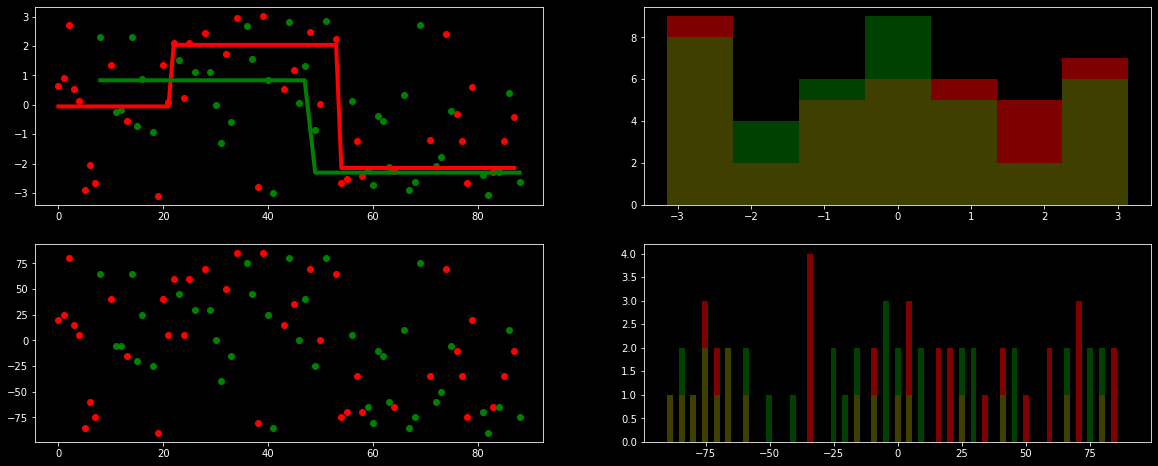

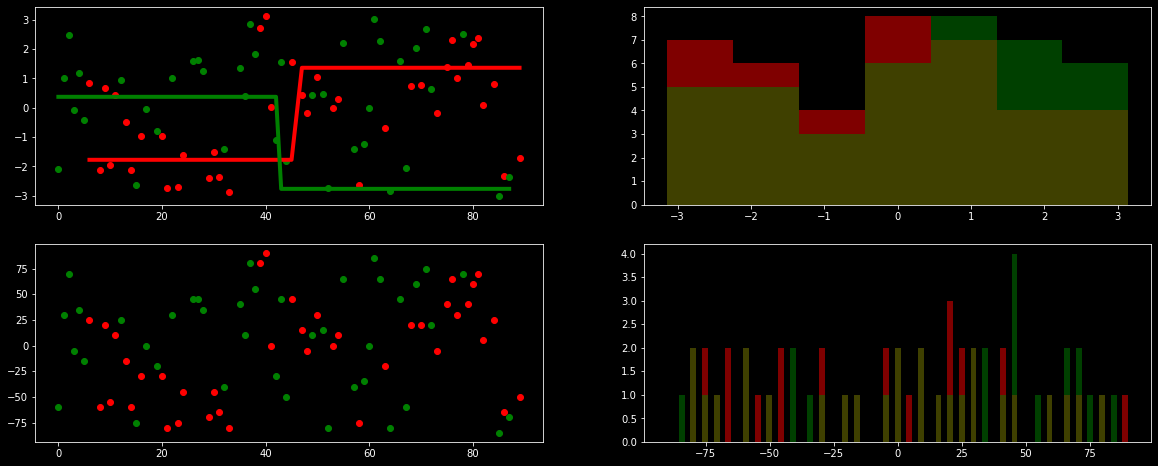

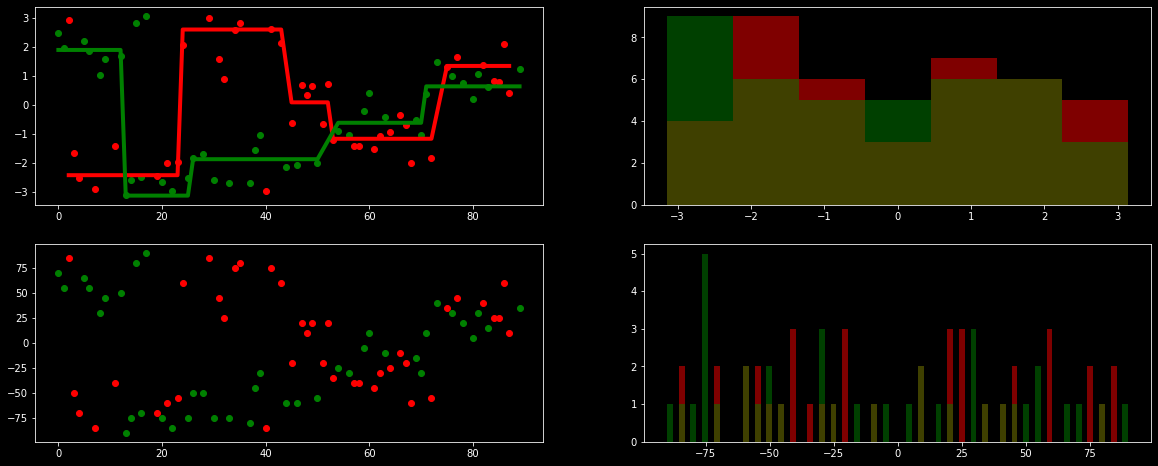

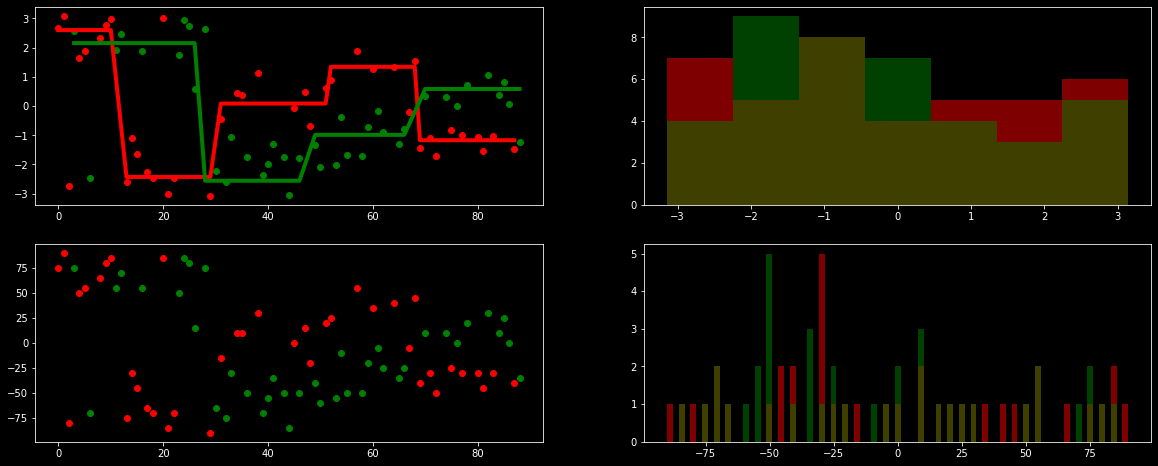

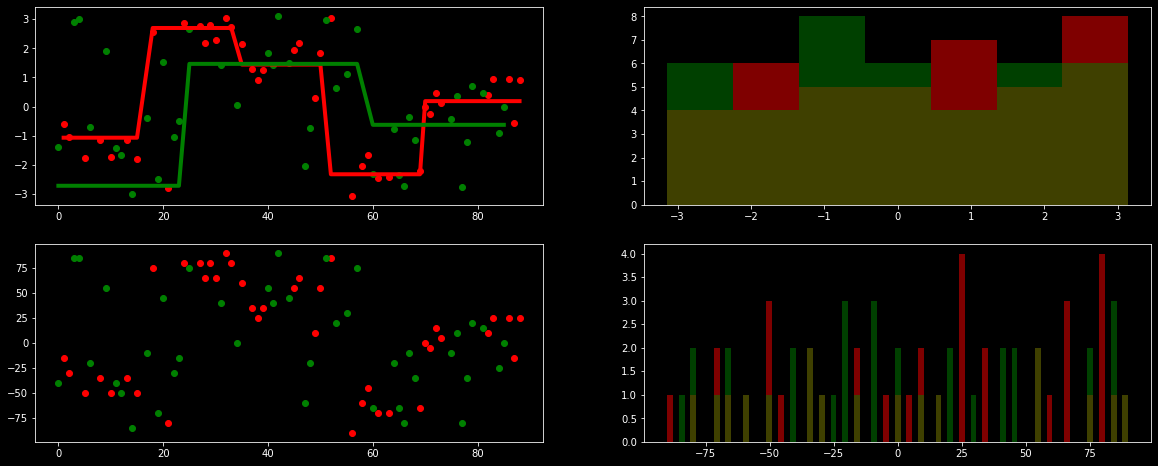

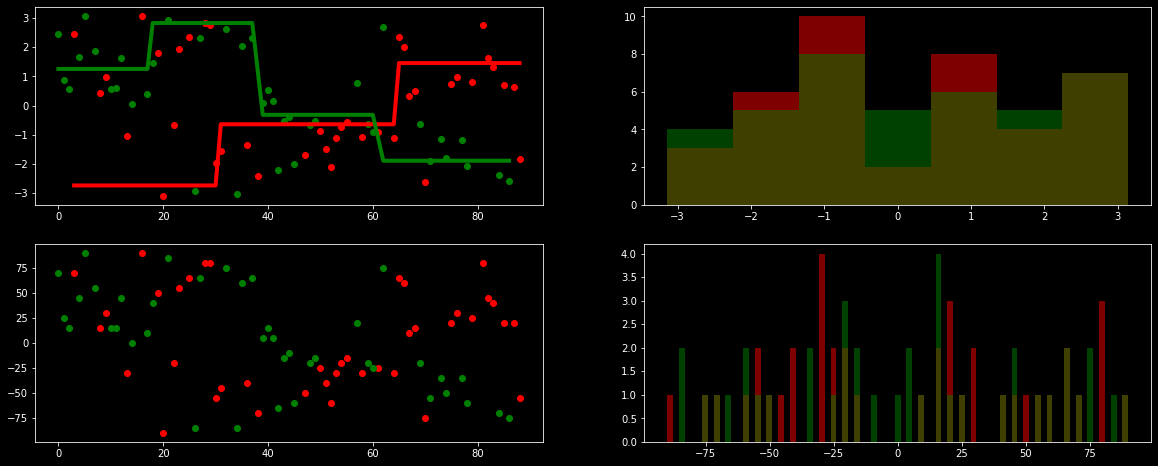

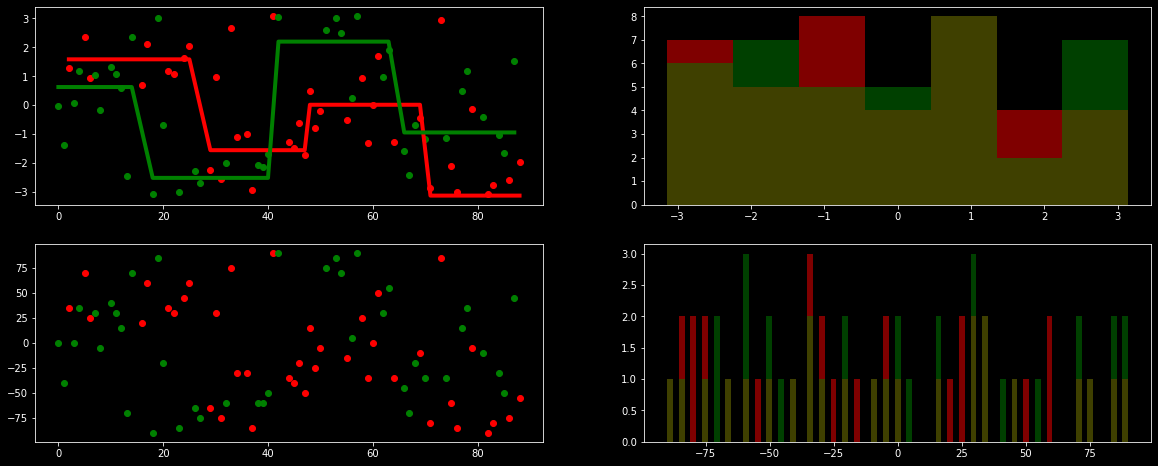

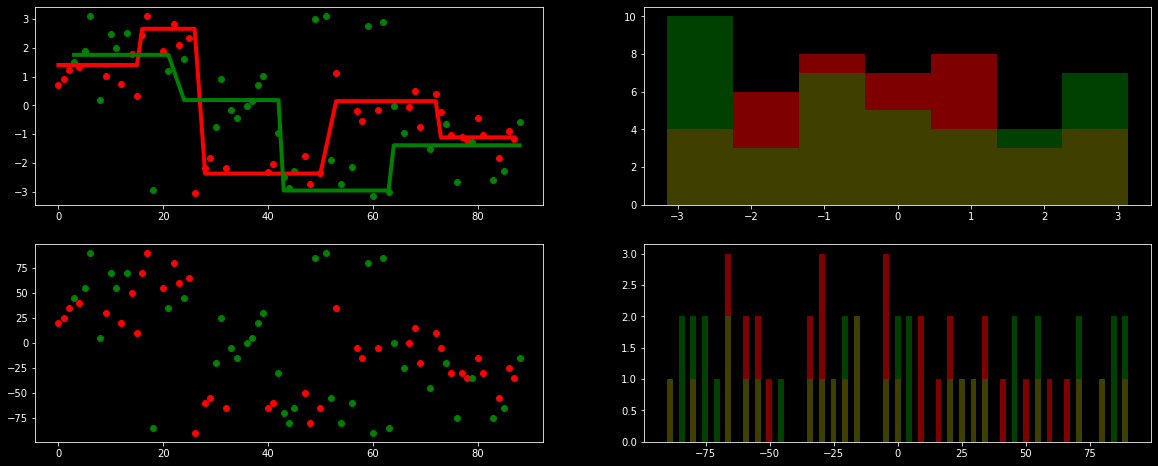

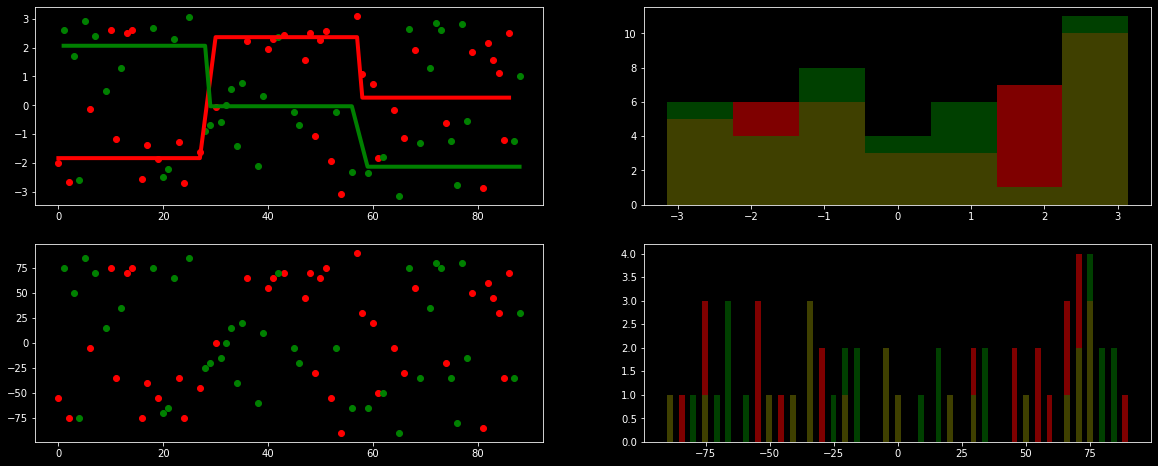

In [117]:
def create_sj_designs(sj, n_train_runs=4, n_test_runs=12):
    os.makedirs(f'run_designs/sub-{str(sj).zfill(2)}', exist_ok=True)
    for i in range(n_train_runs):
        df = train_run_orientations()
        df.to_csv(f'run_designs/sub-{str(sj).zfill(2)}/sub-{str(sj).zfill(2)}_task-train_run-{str(i+1).zfill(2)}.tsv', sep='\t', index=True, na_rep='NA')
        plot_train_run_orientations(df, f'run_designs/sub-{str(sj).zfill(2)}/sub-{str(sj).zfill(2)}_task-train_run-{str(i+1).zfill(2)}.pdf')
    for i in range(n_test_runs):
        df = test_run_orientations()
        df.to_csv(f'run_designs/sub-{str(sj).zfill(2)}/sub-{str(sj).zfill(2)}_task-test_run-{str(i+1).zfill(2)}.tsv', sep='\t', index=True, na_rep='NA')
        plot_test_run_orientations(df, f'run_designs/sub-{str(sj).zfill(2)}/sub-{str(sj).zfill(2)}_task-test_run-{str(i+1).zfill(2)}.pdf')   
    plt.close()
create_sj_designs(1)     